# Low-rank benchmarks for Adaptive joint distribution learning

### first import modules

In [17]:
# import seems necessary to not crash matplotlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as la
import time
import FMCA

## Kernel ridge regression

In [18]:
dim = 3
N = 10000
ridge = 1e-2
rhs = np.ones((N,1), order='F')
cov = FMCA.CovarianceKernel("GAUSSIAN", .5)
pts = np.array(np.random.rand(dim, N), order='F')

### Pivoted Cholesky based ridge regression
Based on the Woodbury matrix identity, we have
$
\boldsymbol B^{-1}=\boldsymbol A^{-1}-\boldsymbol A^{-1}\boldsymbol U
(\boldsymbol I+\boldsymbol V\boldsymbol A^{-1}\boldsymbol U)^{-1}\boldsymbol V\boldsymbol A^{-1}
$ for $\boldsymbol B = \boldsymbol A+\boldsymbol U \boldsymbol V$.
Setting $\boldsymbol A = n\lambda \boldsymbol I$, $\boldsymbol U=\boldsymbol L$ and $\boldsymbol V=\boldsymbol L^T$, 
this yields
$$
(n\lambda\boldsymbol I + \boldsymbol L\boldsymbol L^T)^{-1}
=\frac{1}{n\lambda}(\boldsymbol I-\boldsymbol L(n\lambda\boldsymbol I+\boldsymbol L^T\boldsymbol L)^{-1}\boldsymbol L^T).
$$
We get to a FALKON like low-rank representation of the coefficient $\boldsymbol\alpha$ by setting 
$\boldsymbol\beta=\boldsymbol L^T\boldsymbol\alpha$ and arrive at
$$
\boldsymbol f\approx\boldsymbol L\boldsymbol\beta
$$

In [19]:
chol = FMCA.PivotedCholesky();
tchol = np.zeros((10,1))
errchol = np.zeros((10,1))
Mchol = np.zeros((10,1), dtype=np.uint64)
for i in range(10):
    prec = 10**(-1-i)
    print('prec: ', prec)
    # pivoted Cholesky
    start = time.time()
    chol.compute(cov, pts, prec);
    LTL = chol.matrixL().transpose() @ chol.matrixL()
    M = (LTL.shape)[1]
    Mchol[i] = M
    LTrhs = chol.matrixL().transpose() @ rhs
    beta = (LTrhs - LTL @ np.linalg.solve(N * ridge * np.identity(M) + LTL, LTrhs)) / (N * ridge);
    stop = time.time()
    tchol[i] = stop - start
    errchol[i] = np.linalg.norm((chol.matrixL() @ beta).flatten() - rhs.flatten()) / np.linalg.norm(rhs.flatten())

prec:  0.1
N: 10000 max number of cols: 10000
rel tol: 1000 initial trace: 10000
steps: 14 trace error: 901.456
prec:  0.01
N: 10000 max number of cols: 10000
rel tol: 100 initial trace: 10000
steps: 32 trace error: 87.1813
prec:  0.001
N: 10000 max number of cols: 10000
rel tol: 10 initial trace: 10000
steps: 55 trace error: 9.60922
prec:  0.0001
N: 10000 max number of cols: 10000
rel tol: 1 initial trace: 10000
steps: 82 trace error: 0.995546
prec:  1e-05
N: 10000 max number of cols: 10000
rel tol: 0.1 initial trace: 10000
steps: 116 trace error: 0.0973647
prec:  1e-06
N: 10000 max number of cols: 10000
rel tol: 0.01 initial trace: 10000
steps: 156 trace error: 0.00985126
prec:  1e-07
N: 10000 max number of cols: 10000
rel tol: 0.001 initial trace: 10000
steps: 203 trace error: 0.000913267
prec:  1e-08
N: 10000 max number of cols: 10000
rel tol: 0.0001 initial trace: 10000
steps: 252 trace error: 9.91325e-05
prec:  1e-09
N: 10000 max number of cols: 10000
rel tol: 1e-05 initial trace

### FALKON based ridge regression

In [4]:
falkon = FMCA.FALKON();
tfalkon = np.zeros((10,1))
errfalkon = np.zeros((10,1))
for i in range(10):
    prec = 10**(-1-i)
    M = Mchol[i].item()
    print('prec: ', prec, ' rank: ', M)
    # FALKON (using pivoted Cholesky rank)
    start = time.time()
    falkon.init(cov, pts, M, ridge)
    # we use 20 CG iterations here
    alpha = falkon.computeAlpha(rhs, 20)
    stop = time.time()
    tfalkon[i] = stop - start
    errfalkon[i] = np.linalg.norm((falkon.matrixKPC() @ alpha).flatten() - rhs.flatten()) / np.linalg.norm(rhs.flatten())

prec:  0.1  rank:  13
CG iterations: 14 relative residual: 1.43279e-18
prec:  0.01  rank:  31
CG iterations: 20 relative residual: 2.41313e-15
prec:  0.001  rank:  54
CG iterations: 20 relative residual: 1.77321e-15
prec:  0.0001  rank:  84
CG iterations: 19 relative residual: 4.09124e-17
prec:  1e-05  rank:  115
CG iterations: 17 relative residual: 1.99297e-16
prec:  1e-06  rank:  156
CG iterations: 18 relative residual: 6.58551e-17
prec:  1e-07  rank:  201
CG iterations: 18 relative residual: 1.2023e-16
prec:  1e-08  rank:  252
CG iterations: 17 relative residual: 8.86383e-17
prec:  1e-09  rank:  309
CG iterations: 17 relative residual: 7.81649e-17
prec:  1e-10  rank:  378
CG iterations: 17 relative residual: 3.28154e-17


### visualize results
We expect a runtime of $\mathcal{O}(nM^2)$ for pivoted Cholesky and of $\mathcal{O}(tnM)$ for FALKON.

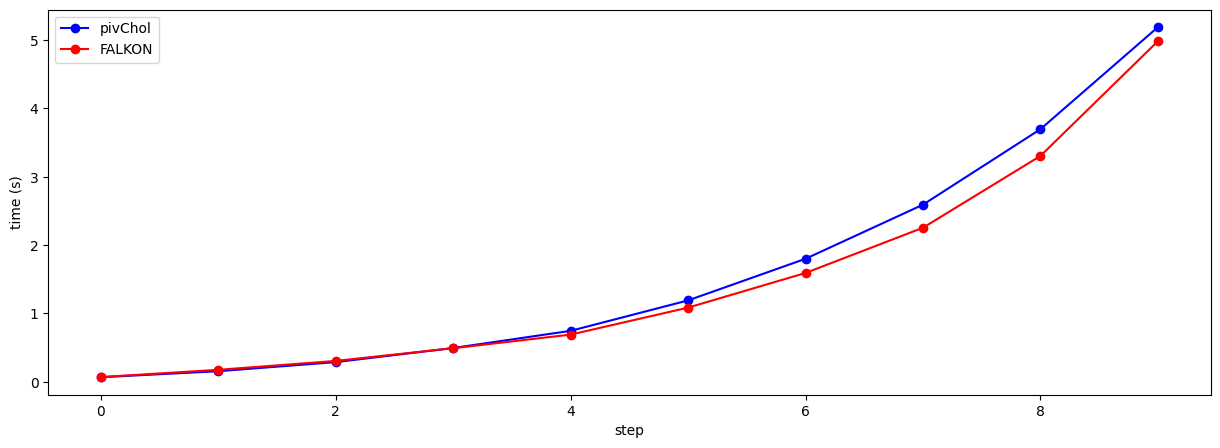

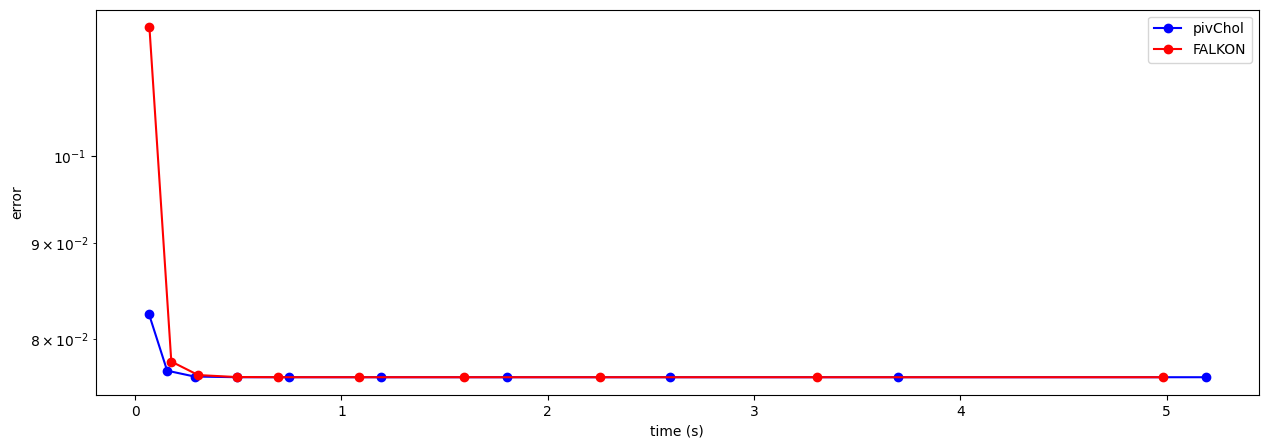

In [5]:
plt.figure(figsize=(15,5))
plt.plot(range(10), tchol, 'bo-', label='pivChol')
plt.plot(range(10), tfalkon, 'ro-', label='FALKON')
plt.xlabel("step")
plt.ylabel("time (s)")
plt.legend()
plt.show()
plt.figure(figsize=(15,5))
plt.semilogy(tchol,errchol, 'bo-', label='pivChol')
plt.semilogy(tfalkon, errfalkon, 'ro-', label='FALKON')
plt.xlabel("time (s)")
plt.ylabel("error")
plt.legend()
plt.show()

## Conditional mean embedding (CME)

As a hypothesis space, we consider a tensor product RKHS 
$\mathcal{H}=\mathcal{H}_X \otimes \mathcal{H}_Y$ to
estimate, for any $x\in \mathcal{X}$, the conditional expectation operator 
$\mu _{Y|X=x}\in \mathcal{H}_Y$ acting as a linear functional on $\mathcal{H}_Y$, i.e.,
$$
 \langle f,\mu _{Y|X=x} \rangle _{\mathcal{H}_{Y}}=\int_{\mathcal{Y}} f\mathrm{d}\mathbb 
 P_{Y|X=x},\quad\text{for all $f\in \mathcal{H}_Y$.}
$$
We make a tensor product ansatz, which yields
$$
  \boldsymbol F=(\boldsymbol K_X+n\lambda \boldsymbol I_n)^{-1}, \, \text{ and  } 
  \hat{\mu} _{Y|X=\cdot}= {\boldsymbol\Phi}_Y(\cdot)(\boldsymbol K_X
  +n\lambda \boldsymbol I_n)^{-1} {\boldsymbol\Phi}_X(\cdot)^T.
$$
This estimator of the conditional expectation operator results in
$$
 \langle f,\hat{\mu}_{Y|X=x} \rangle _{\mathcal{H}_{Y}}=[f(y_1),\dots,f(y_n)] 
 \boldsymbol F {\boldsymbol\Phi}_X^T(x)\quad\text{for all $f\in \mathcal{H}_Y$.}
 $$

### Conditional mean embedding full rank
We compute the conditional mean embedding without low-rank

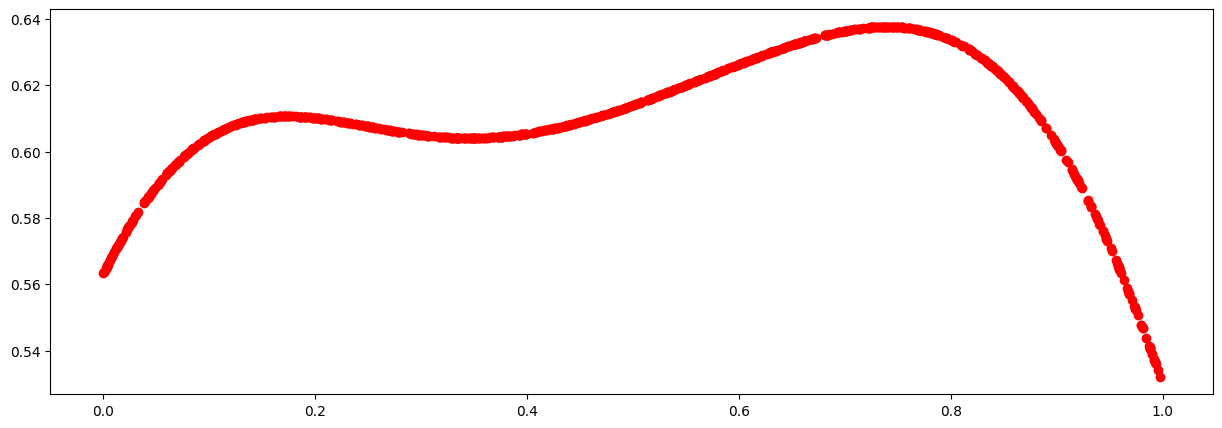

In [42]:
dimX = 1
NX = 1000
dimY = 2
NY = 1000
covX = FMCA.CovarianceKernel("GAUSSIAN", .25)
covY = FMCA.CovarianceKernel("GAUSSIAN", .5)
ptsX = np.array(np.random.rand(dimX, NX), order='F')
ptsY = np.array(np.random.rand(dimY, NY), order='F')
ridge = 1e-2
fY = covY.eval(ptsY,ptsY[:,0])
fXY = np.zeros((NX, 1), order='F')
KX = covX.eval(ptsX, ptsX)
for i in range(NX):
    PhiXx = covX.eval(ptsX, ptsX[:,i])
    fXY[i] = fY.transpose() @ np.linalg.solve(NX * ridge * np.identity(NX) + KX, PhiXx)
plt.figure(figsize=(15,5))
plt.plot(ptsX, fXY.transpose(), 'ro')
plt.show()

### Low-rank conditional mean embedding I
We compare the results above to the pivoted Cholesky variant based on the doubly orthogonal basis
Using low-rank approximations of the involved kernels, with doubly orthogonal bases $\boldsymbol Q_{X}, \boldsymbol Q_{Y}$
$$
      \boldsymbol F= \boldsymbol B_{Y} \boldsymbol V _Y 
      \tilde { \boldsymbol F} \boldsymbol V _X^T \boldsymbol B_{X}^{T}=\boldsymbol Q_Y\tilde { \boldsymbol F}
      \boldsymbol Q_X^T,
$$
where
$$
\tilde{\boldsymbol F}^{T}=\boldsymbol Q_Y^T\boldsymbol Q_X(\boldsymbol\Lambda _X+n\lambda \boldsymbol I_{m_X})^{-1}.
$$
This means, by the way that actually
$$
\boldsymbol F=\boldsymbol{Q}_Y\boldsymbol{Q}_Y^\intercal\boldsymbol{Q}_X(\boldsymbol\Lambda _X+n\lambda \boldsymbol I_{m_X})^{-1}\boldsymbol{Q}_X^\intercal
$$
The cost for computing $\tilde{\boldsymbol F}^{T}$ is $\mathcal{O}(M^2n)$. Afterwards, due to the sparsity of
$\boldsymbol B_X$, the CME can be evaluated with cost $\mathcal{O}(M^2)$.


N: 1000 max number of cols: 1000
rel tol: 1e-05 initial trace: 1000
steps: 12 trace error: 1.02386e-06
N: 1000 max number of cols: 1000
rel tol: 1e-05 initial trace: 1000
steps: 47 trace error: 7.66944e-06
setup time for low-rank CME: 0.09103083610534668 sec.
evaluation time for low-rank CME: 0.01699090003967285 sec.


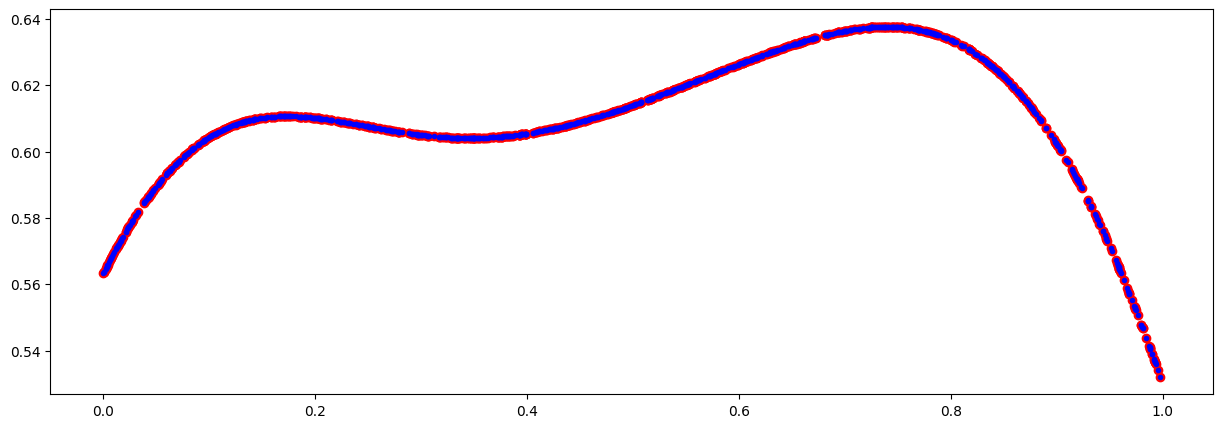

In [43]:
cholX = FMCA.PivotedCholesky()
cholY = FMCA.PivotedCholesky()
start = time.time()
cholX.compute(covX, ptsX, 1e-8)
cholY.compute(covY, ptsY, 1e-8)
cholX.computeBiorthogonalBasis()
cholY.computeBiorthogonalBasis()
idX = cholX.indices()
idY = cholY.indices()
mX = idX.shape[0]
mY = idY.shape[0]
CX = np.zeros((dimX, mX), order='F')
CY = np.zeros((dimY, mY), order='F')
for i in range(mX):
    CX[:,i] = ptsX[:, idX[i]]
for i in range(mY):
    CY[:,i] = ptsY[:, idY[i]]
KXNC = covX.eval(ptsX, CX)
KYNC = covY.eval(ptsY, CY)
WX = cholX.spectralBasisWeights()
WY = cholY.spectralBasisWeights()
QX = KXNC @ WX
QY = KYNC @ WY
QYTQX = QY.transpose() @ QX
invEvsPridge = 1 / (cholX.eigenvalues() + NX * ridge)
stop = time.time()
print('setup time for low-rank CME:', stop - start, 'sec.')
start = time.time()
fXYchol = np.zeros((NX, 1), order='F')
for i in range(NX):
    PhiXx = covX.eval(CX, ptsX[:,i])
    fXYchol[i] = fY[idY,:].transpose() @ (WY @  (QYTQX @ (np.diag(invEvsPridge) @ (WX.transpose() @ PhiXx))))
stop = time.time()
print('evaluation time for low-rank CME:', stop - start, 'sec.')
plt.figure(figsize=(15,5))
plt.plot(ptsX, fXY.transpose(), 'ro')
plt.plot(ptsX, fXYchol.transpose(), 'b.')
plt.show()


### Low-rank conditional mean embedding II
Instead of resorting to the doubly orthogonal basis, we next consider a
variant based on the low-rank inverse based on $\boldsymbol K_X\approx \boldsymbol L_X\boldsymbol L_X^T$, i.e.,
$$
(n\lambda\boldsymbol I + \boldsymbol L\boldsymbol L^T)^{-1}
=\frac{1}{n\lambda}(\boldsymbol I-\boldsymbol L(n\lambda \boldsymbol I+\boldsymbol L^T\boldsymbol L)^{-1}\boldsymbol L^T).
$$

setup time for Cholesky inverse: 0.0023360252380371094 sec.
evaluation time for low-rank CME: 0.3580207824707031 sec.


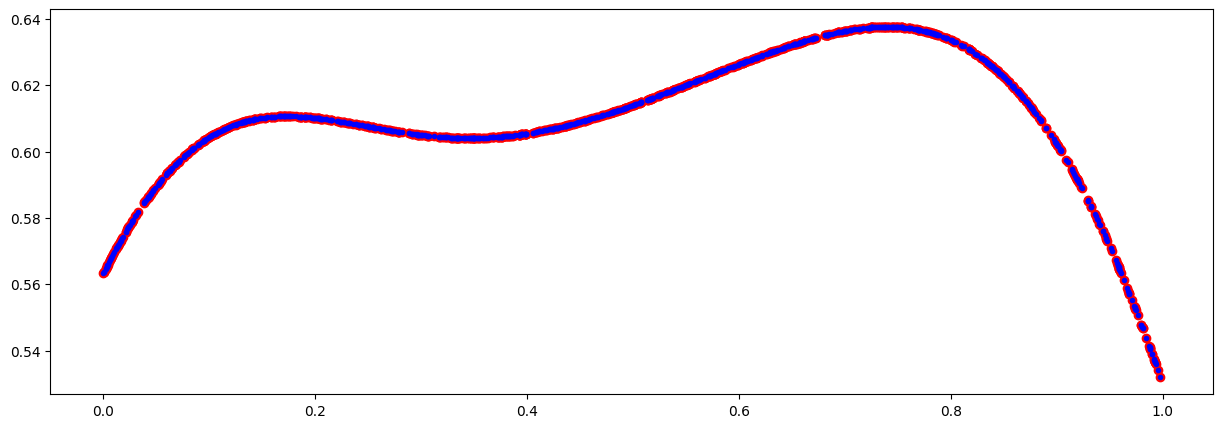

In [44]:
start = time.time()
LTL = cholX.matrixL().transpose() @ cholX.matrixL()
invLTL = np.linalg.solve(NX * ridge * np.identity(mX) + LTL, np.identity(mX))
L = cholX.matrixL()
stop = time.time()
stop = time.time()
print('setup time for Cholesky inverse:', stop - start, 'sec.')
start = time.time()
fXYlr = np.zeros((NX, 1), order='F')
for i in range(NX):
    PhiXx = covX.eval(ptsX, ptsX[:,i])
    alpha = (PhiXx - (L @ (invLTL @ (L.transpose() @ PhiXx)))) / (NX * ridge)
    fXYlr[i] = fY.transpose() @ alpha
stop = time.time()
print('evaluation time for low-rank CME:', stop - start, 'sec.')
plt.figure(figsize=(15,5))
plt.plot(ptsX, fXY.transpose(), 'ro')
plt.plot(ptsX, fXYlr.transpose(), 'b.')
plt.show()

### Falkon CME
FALKON employs the low-rank approximation
$$
\tilde{s}_{\lambda,M}(x)=\sum_{i=1}^M\tilde{\alpha}_iK(x,\tilde{x}_i)\quad\text{with }\{\tilde{x}_1,\ldots,\tilde{x}_M\}
\subset\{x_1,\ldots,x_n\}.
$$
Herein, the coefficients are obtained by solving the linear system
$$
(\boldsymbol K_{nM}^T\boldsymbol K_{nM}+\lambda n\boldsymbol K_{MM})\tilde{\boldsymbol\alpha}=
\boldsymbol H{\boldsymbol\alpha}=
\boldsymbol K_{nM}^T\boldsymbol y
$$
or
$$
\tilde{\boldsymbol\alpha}={\boldsymbol H}^{-1}\boldsymbol K_{nM}^T\boldsymbol y.
$$
To exploit this for the CME, we again consider the Woodbury matrix identity, we have
$
\boldsymbol B^{-1}=\boldsymbol A^{-1}-\boldsymbol A^{-1}\boldsymbol U
(\boldsymbol I+\boldsymbol V\boldsymbol A^{-1}\boldsymbol U)^{-1}\boldsymbol V\boldsymbol A^{-1}
$ for $\boldsymbol B = \boldsymbol A+\boldsymbol U \boldsymbol V$.
Setting $\boldsymbol A = n\lambda \boldsymbol I$, $\boldsymbol U=\boldsymbol K_{nM}$ and $\boldsymbol V=
\boldsymbol K_{MM}^{-1}\boldsymbol K_{nM}^T$, we obtain
$$
\begin{aligned}
(n\lambda \boldsymbol I+\boldsymbol K_{nM}\boldsymbol K_{MM}^{-1}\boldsymbol K_{nM}^T)^{-1}
&=\frac{1}{n\lambda}\boldsymbol I-
\frac{1}{n\lambda}\boldsymbol K_{nM}(n\lambda\boldsymbol I
+\boldsymbol K_{MM}^{-1}\boldsymbol K_{nM}^T\boldsymbol K_{nM})^{-1}\boldsymbol K_{MM}^{-1}\boldsymbol K_{nM}^T\\
&=\frac{1}{n\lambda}\boldsymbol I-
\frac{1}{n\lambda}\boldsymbol K_{nM}(n\lambda\boldsymbol K_{MM}
+\boldsymbol K_{nM}^T\boldsymbol K_{nM})^{-1}\boldsymbol K_{nM}^T.
\end{aligned}
$$
Letting $\boldsymbol f={\boldsymbol\Phi}_X^T(x)$, this yields
we can also use FALKON for the CME, resulting in the representation
$$
 \langle f,\hat{\mu}_{Y|X=x} \rangle _{\mathcal{H}_{Y}}=
 \frac{1}{n\lambda}[f(y_1),\dots,f(y_n)]
 (\boldsymbol I-\boldsymbol K_{nM}{\boldsymbol H}^{-1}\boldsymbol K_{nM}^T)\boldsymbol{\boldsymbol\Phi}_X^T(x).
$$
The cost for evaluating this representation is $\mathcal{O}(nM)$.

setup time for FALKON CME: 0.07533907890319824 sec.
CG iterations: 9 relative residual: 1.18355e-17
CG iterations: 9 relative residual: 1.22863e-17
CG iterations: 9 relative residual: 9.27101e-18
CG iterations: 9 relative residual: 4.15196e-18
CG iterations: 9 relative residual: 1.28835e-17
CG iterations: 9 relative residual: 1.14791e-17
CG iterations: 9 relative residual: 1.20123e-17
CG iterations: 9 relative residual: 1.29029e-17
CG iterations: 9 relative residual: 1.2835e-17
CG iterations: 9 relative residual: 7.95546e-18
CG iterations: 9 relative residual: 1.13006e-17
CG iterations: 9 relative residual: 1.20652e-17
CG iterations: 9 relative residual: 1.03431e-17
CG iterations: 9 relative residual: 6.49739e-18
CG iterations: 9 relative residual: 1.28196e-17
CG iterations: 9 relative residual: 1.04847e-17
CG iterations: 9 relative residual: 1.2175e-17
CG iterations: 9 relative residual: 8.33064e-18
CG iterations: 9 relative residual: 7.16318e-18
CG iterations: 9 relative residual: 6.

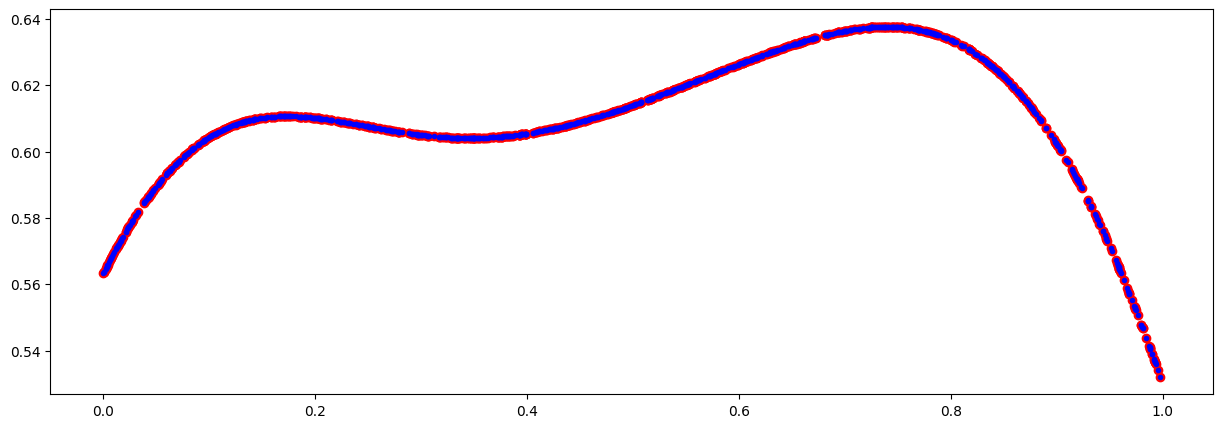

In [46]:
falkonX = FMCA.FALKON();
start = time.time()
falkonX.init(covX, ptsX, 100, ridge)
stop = time.time()
print('setup time for FALKON CME:', stop - start, 'sec.')
start = time.time()
fXYfalkon = np.zeros((NX, 1), order='F')
for i in range(NX):
    PhiXx = covX.eval(ptsX, ptsX[:,i])
    alphat = falkonX.computeAlpha(PhiXx, 10)
    alpha = (PhiXx.flatten() - falkonX.matrixKPC() @ alphat) / (NX * ridge)
    fXYfalkon[i] = np.dot(fY.flatten(),alpha)
stop = time.time()
print('evaluation time for FALKON CME:', stop - start, 'sec.')
plt.figure(figsize=(15,5))
plt.plot(ptsX, fXY.transpose(), 'ro')
plt.plot(ptsX, fXYfalkon.transpose(), 'b.')
plt.show()